In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import cv2
import time

%run utils/datasets.ipynb

font = cv2.FONT_HERSHEY_TRIPLEX
font_scale = 1
thickness = 1
alpha = 0.5
color = (0, 0, 0)

WIDTH = 320
HEIGHT = 240
WINDOW_H, WINDOW_W = 240, 320
IMAGE_W = 320
ADDED_D = 4
MAX_D = 101
MARGIN = 5
ROOT_FOLDER = "D:/dataset/test/data_test"

IMAGES = [
    "D:/dataset/test/data_test/01328.jpg",
    "D:/dataset/test/data_test/02376.jpg",
    "D:/dataset/test/data_test/13050.jpg",
    "D:/dataset/test/data_test/16042.jpg"
]
MODEL_NAME = "model_kitti_unet_1719391955.keras"

model = tf.keras.models.load_model(MODEL_NAME, compile=False)

In [2]:
def draw_distances(image, prediction, points):
    depth3 = image.copy()
    
    font = cv2.FONT_HERSHEY_SIMPLEX 
    font_scale = 0.5
    color = (255, 0, 0)
    thickness = 1
    
    find = points.copy()
    
    for h in range(HEIGHT - 1, 0, -1):
        for w in range(WIDTH):
            if find[h, w] > 128:
                dist = ADDED_D + prediction[h, w, 0] * MAX_D
                text = f"{dist:.2f} m"
                text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
                text_pos = w - text_size[0] // 2, h
                rectangle = np.ones((text_size[1] + 2, text_size[0], 3), np.uint8) * 255
                alpha = 0.5
                try:
                    depth3[text_pos[1] - text_size[1] // 2: text_pos[1] + text_size[1] // 2 + 2, text_pos[0] : text_pos[0] + text_size[0]] = \
                        cv2.addWeighted(depth3[text_pos[1] - text_size[1] // 2: text_pos[1] + text_size[1] // 2 + 2, text_pos[0] : text_pos[0] + text_size[0]],
                                        alpha, rectangle, 1 - alpha, 0)
                    depth3 = cv2.putText(depth3, text,
                                         (text_pos[0], text_pos[1] + text_size[1] // 2), font,
                                         font_scale, color, thickness, cv2.LINE_AA)
                    t_w = text_size[0]
                    t_h = text_size[1]
                    depth3[h, w] = (0,0,255)
                    depth3 = cv2.line(depth3, ((WINDOW_X + WINDOW_W // 2 - 788) // 2, 726 // 2), (w, h), (0, 0, 255))
                    find[max(0, h - t_h - 1) : min(h + t_h + 1, HEIGHT - 1), max(0, w - t_w - 1) : min(w + t_w + 1, WIDTH - 1)] = 0
                except:
                    pass
    return depth3

D:/dataset/test/data_test/01328.jpg
D:/dataset/test/data_test/02376.jpg
D:/dataset/test/data_test/13050.jpg
D:/dataset/test/data_test/16042.jpg
4/4 [==============================] - 4s 14ms/step


<Figure size 640x480 with 0 Axes>

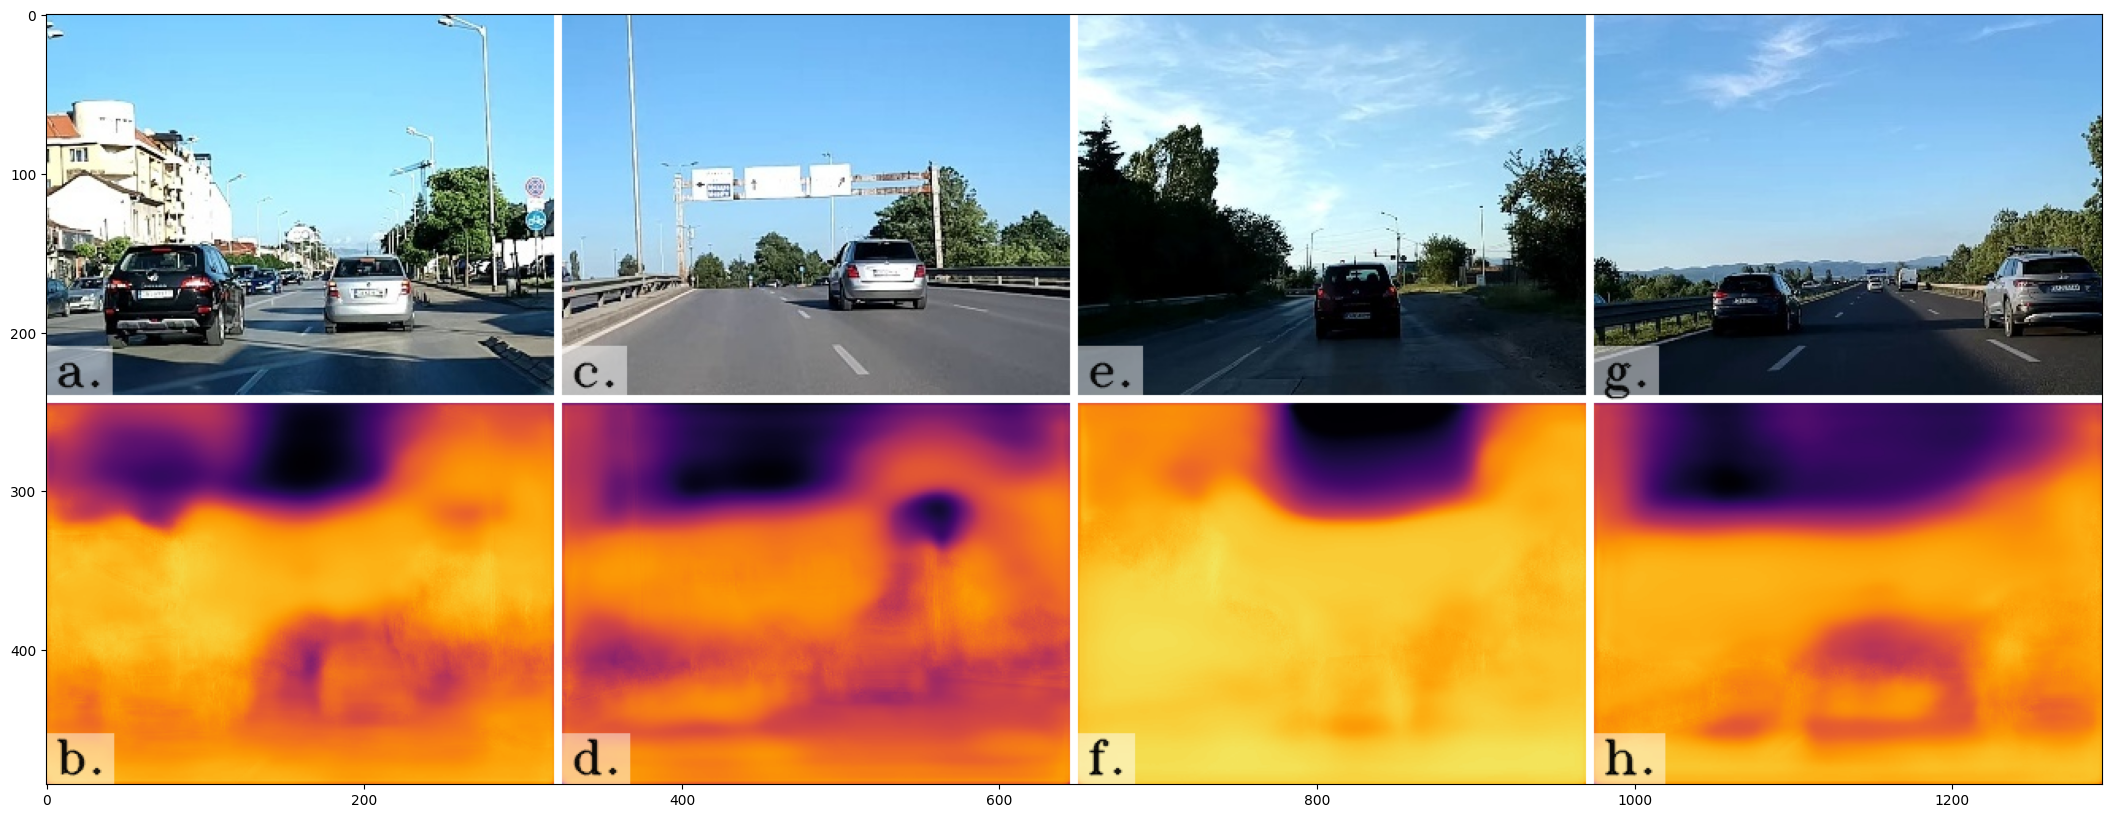

In [3]:
depths = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))
images = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))
x_test = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))

for i in range(len(IMAGES)):
    print(IMAGES[i])
    image = cv2.imread(IMAGES[i])
    
    if image is None:
        print(f"Failed to load image: {IMAGES[i]}")
        continue
    
    IMAGE_H, IMAGE_W = image.shape[:2]
    if IMAGE_W < WINDOW_W:
        print(f"Image width is smaller than window width: {IMAGES[i]}")
        continue
    
    image2 = image[:WINDOW_H, (IMAGE_W - WINDOW_W) // 2 : (IMAGE_W + WINDOW_W) // 2, :]
    
    if image2.size == 0:
        print(f"Failed to crop image correctly: {IMAGES[i]}")
        continue
    
    cv2.imwrite(f"{ROOT_FOLDER}/tmp.jpg", image2)
    
    x_test[i, ] = preprocess_image(f"{ROOT_FOLDER}/tmp.jpg", HEIGHT, WIDTH, depth=False, horizontal_flip=False)

predictions = model.predict(x_test, batch_size=1)

for k in range(len(IMAGES)):
    img1 = x_test[k, ].copy()
    images[k] = (img1 * 255).astype(np.uint8)
    depth = ADDED_D + predictions[k] * MAX_D
    depth = (depth / np.max(depth) * 255).astype(np.uint8)
    depths[k] = cv2.applyColorMap(255 - depth, cv2.COLORMAP_INFERNO)

fig = (np.ones((HEIGHT * 2 + MARGIN, WIDTH * 4 + 3 * MARGIN, 3)) * 255).astype(np.uint8)
fig[:HEIGHT, :WIDTH] = images[0]
fig[HEIGHT + MARGIN:, :WIDTH] = depths[0]
fig[:HEIGHT, WIDTH + MARGIN : 2 * WIDTH + MARGIN] = images[1]
fig[HEIGHT + MARGIN:, WIDTH + MARGIN : 2 * WIDTH + MARGIN] = depths[1]
fig[:HEIGHT, 2 * WIDTH + 2 * MARGIN : 3 * WIDTH + 2 * MARGIN] = images[2]
fig[HEIGHT + MARGIN:, 2 * WIDTH + 2 * MARGIN : 3 * WIDTH + 2 * MARGIN] = depths[2]
fig[:HEIGHT, 3 * WIDTH + 3 * MARGIN:] = images[3]
fig[HEIGHT + MARGIN:, 3 * WIDTH + 3 * MARGIN:] = depths[3]

labels = [("a.", 0, HEIGHT),
          ("b.", 0, 2 * HEIGHT + MARGIN - 1),
          ("c.", WIDTH + MARGIN, HEIGHT),
          ("d.", WIDTH + MARGIN, 2 * HEIGHT + MARGIN - 1),
          ("e.", 2 * WIDTH + 2 * MARGIN, HEIGHT),
          ("f.", 2 * WIDTH + 2 * MARGIN, 2 * HEIGHT + MARGIN - 1),
          ("g.", 3 * WIDTH + 3 * MARGIN, HEIGHT),
          ("h.", 3 * WIDTH + 3 * MARGIN, 2 * HEIGHT + MARGIN - 1)]

for k in range(len(labels)):
    text, w, h = labels[k]
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255  
    fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10] = \
                        cv2.addWeighted(fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10], alpha, rectangle, 1 - alpha, 0)
    fig = cv2.putText(fig, text, (w + 5, h - text_size[1] // 2 + 5), font, font_scale, color, thickness, cv2.LINE_AA)

cv2.imwrite("fig4.jpg", fig)

plt.figure(100)
plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(fig, cv2.COLOR_BGR2RGB))
plt.show()

Image 1 processing time: 2296 ms
Image 2 processing time: 2091 ms
Image 3 processing time: 2163 ms


<Figure size 640x480 with 0 Axes>

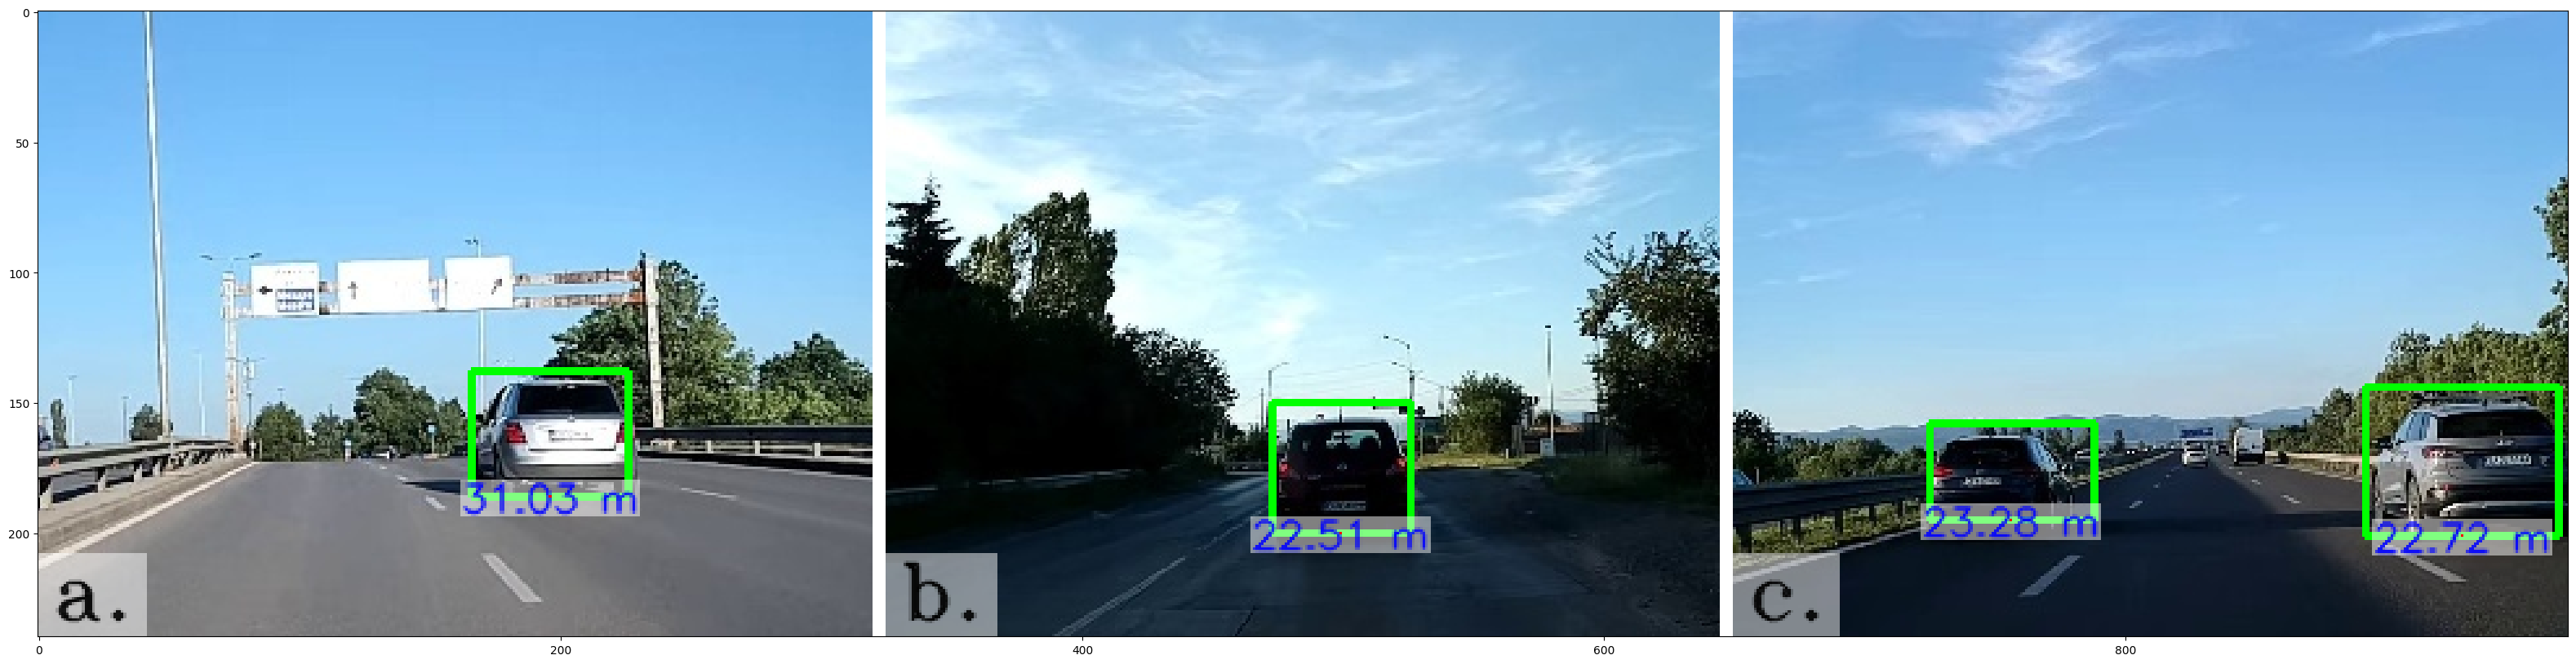

In [4]:
net = cv2.dnn.readNetFromTensorflow('mask_rcnn_inception_v2_coco_2018_01_28.pb', 'mask_rcnn_inception_v2_coco_2018_01_28.pbtxt')

images = np.empty((len(IMAGES), HEIGHT, WIDTH, 3))

for k in range(1, len(IMAGES)):
    start = time.time()
    
    img1 = x_test[k, ].copy()
    img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    normalized = cv2.resize(img1, (320, 240))

    # Prepare the depth image for inference
    blob = cv2.dnn.blobFromImage(normalized, swapRB=True, crop=False)
    net.setInput(blob)
    
    # Perform object detection
    boxes, masks = net.forward(["detection_out_final", "detection_masks"])
    
    points = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
    
    # Iterate through the detected objects
    for i in range(boxes.shape[2]):
        confidence = boxes[0, 0, i, 2]
        if confidence > 0.5:  # Filter out weak detections
            class_id = int(boxes[0, 0, i, 1])
            
            if class_id != 0:  # We only consider non-background classes
                # Extract the bounding box coordinates
                box = boxes[0, 0, i, 3:7] * np.array([320, 240, 320, 240])
                x1, y1, x2, y2 = box.astype(int)
                w = x2 - x1
                h = y2 - y1
    
                points[y1 + h, x1 + w // 2] = 255
                
                # Optionally, you can draw the bounding box on the original depth image
                cv2.rectangle(normalized, (x1, y1), (x2, y2), (0, 255, 0), 2)
    print(f"Image {k} processing time: {int((time.time() - start) * 1000)} ms")
    
    image = cv2.cvtColor(normalized, cv2.COLOR_RGB2BGR)
    image =  draw_distances(image, predictions[k], points)

    images[k,] = image

fig = (np.ones((HEIGHT, WIDTH * 3 + 2 * MARGIN, 3)) * 255).astype(np.uint8)
fig[:HEIGHT, :WIDTH] = images[1]
fig[:HEIGHT, WIDTH + MARGIN:2 * WIDTH + MARGIN] = images[2]
fig[:HEIGHT, 2 * WIDTH + 2 * MARGIN:] = images[3]

labels = [("a.", 0, HEIGHT - 1),
          ("b.", WIDTH + MARGIN, HEIGHT - 1),
          ("c.", 2 * WIDTH + 2 * MARGIN, HEIGHT - 1)]

for k in range(len(labels)):
    text, w, h = labels[k]
    text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
    rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255  
    fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10] = \
                        cv2.addWeighted(fig[h - text_size[1] - 9 : h + 1, w : w + text_size[0] + 10], alpha, rectangle, 1 - alpha, 0)
    fig = cv2.putText(fig, text, (w + 5, h - text_size[1] // 2 + 5), font, font_scale, color, thickness, cv2.LINE_AA)

cv2.imwrite("fig7.jpg", fig)

plt.figure(100)
plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(fig, cv2.COLOR_BGR2RGB))